In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
from rouge_score import rouge_scorer
from bert_score import score
#import datasets
#from evaluate import load
import torch
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import nltk
from transformers import MBartForConditionalGeneration, MBartTokenizer, MBart50TokenizerFast

/home/ralarcon/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-08-31 19:23:38.997430: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
#Get data
df = pd.read_csv('Datasets/train', error_bad_lines=False, sep=';')
df = df[['cod','original','simplified']]

df = df.applymap(str)
articles = df


n_labels = len(articles["original"].unique())
print(n_labels)
articles

3665


/tmp/ipykernel_797635/2813172692.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/home/ralarcon/Data_augmentation/split/train.csv', error_bad_lines=False, sep=';')


,cod,original,simplified
0,6387,"Esta iniciativa hace hincapié en la importancia de limpiarse la lengua, ya que si se lleva a cabo una o dos veces al día, además de prevenir diversas patologías orales, se contribuye a la mejora del sentido del gusto","Esta iniciativa hace hincapié en la importancia de limpiarse la lengua, ya que si se lleva a cabo una o dos veces al día, además de prevenir diversas enfermedades orales, se contribuye a la mejora del sentido del gusto"
1,8492,"Trastornos del sistema inmune Raras: reacciones anafilÃ¡cticas/anafilactoides, incluyendo casos muy raros de urticaria, angioedema y reacciones graves con sÃ­ntomas respiratorios y circulatorios.","Trastornos del sistema inmune Raras: reacciones anafilÃ¡cticas/anafilactoides, incluyendo casos muy raros de urticaria, hinchazÃ³n debajo de la piel y reacciones graves con sÃ­ntomas respiratorios y circulatorios."
2,7926,"TambiÃ©n puede aparecer angioedema de intensidad leve, por ejemplo de afectaciÃ³n maleolar.","TambiÃ©n puede aparecer hinchazÃ³n debajo de la piel de intensidad leve, por ejemplo de afectaciÃ³n maleolar."
3,8072,Frecuentes: temblores.,Frecuentes: temblor.
4,776,"Todas las personas y entidades interesadas en asistir a las I Jornadas Intergeneracionales sobre prevención de los Malos Tratos y Abusos a Personas Mayores que se celebrarán en Madrid los días 26 y 27 de noviembre en la Sala Europa de la Comisión Europea de Madrid, ya pueden inscribirse como asistentes","Todas las personas y entidades interesadas en asistir a las I Jornadas Intergeneracionales sobre prevención de los Malos Tratos y Abusos a Personas Mayores que se harán en Madrid los días 26 y 27 de noviembre en la Sala Europa de la Comisión Europea de Madrid, ya pueden inscribirse como asistentes"
...,...,...,...
7294,5991,"Hoy, 21 de marzo, se conmemora el Día Internacional de la Cefalea en Racimos, el segundo tipo de cefalea primaria más frecuente tras la migraña","Hoy, 21 de marzo, se recuerda el Día Internacional de la Cefalea en Racimos, el segundo tipo de cefalea primaria más frecuente tras la migraña"
7295,9047,"Trastornos del sistema nervioso Poco frecuentes: mareos, cefalea, somnolencia.","Trastornos del sistema nervioso Poco frecuentes: mareo, dolor de cabeza, somnolencia."
7296,3089,"""El impacto de la «X Solidaria» es un ejemplo paradigmático de eficacia, pues son pocas las políticas públicas que consiguen hacer tanto bien con tan pocos recursos"", señaló la secretaria de Estado","""El impacto de la «X Solidaria» es un ejemplo modélico de eficacia, pues son pocas las políticas públicas que consiguen hacer tanto bien con tan pocos recursos"", señaló la secretaria de Estado"
7297,7817,"Dentro de esta iniciativa y con motivo del Día de la Solidaridad Intergeneracional, la Plataforma Canal Sénior han recopilado una gran variedad de cursos gratuitos, con el objetivo de que cualquier persona mayor pueda aprender durante esta cuarentena para estar más conectada con su entorno, a través de cursos online que pueden realizarse en cualquier momento sobre WhatsApp, cursos de consumo o cursos orientados a aprender a comprar.","Dentro de esta iniciativa y con motivo del Día de la Solidaridad Intergeneracional, la Plataforma Canal Sénior han seleccionado una gran variedad de cursos gratuitos, con el objetivo de que cualquier persona mayor pueda aprender durante esta cuarentena para estar más conectada con su entorno, a través de cursos online que pueden realizarse en cualquier momento sobre WhatsApp, cursos de consumo o cursos orientados a aprender a comprar."


In [5]:
#Import model
pretrained_model_name = "eslamxm/MBART-finetuned-Spanish"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=MBartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('mbart',
 transformers.models.mbart.configuration_mbart.MBartConfig,
 transformers.models.mbart50.tokenization_mbart50_fast.MBart50TokenizerFast,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration)

In [6]:
text_gen_kwargs = {}
text_gen_kwargs = {'length_penalty': 1.0, 'max_length': 60, 'min_length': 10, 'num_beams': 4}

In [7]:
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args:
        del text_gen_kwargs[k]

In [8]:
if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["es_XX"]
    
tok_kwargs = {}

In [9]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("original"), get_y=ColReader("simplified"), splitter=RandomSplitter())


In [10]:
dls = dblock.dataloaders(articles, bs=1)

In [11]:
dls.show_batch(dataloaders=dls, max_n=3)

,text,target
0,"es_XX Sistema Reacciones adversas del fÃ¡rmaco Trastornos del sistema inmunolÃ3gico Frecuencia no conocida Hipersensibilidad, angioedema, reacciÃ3n alÃ©rgica Trastornos de la sangre y del sistema linfÃ¡tico Raras Neutropenia Trastornos del metabolismo y de la nutriciÃ3n Frecuentes Aumento del apetito Poco frecuentes Anorexia Raras Hipoglucemia Trastornos psiquiÃ¡tricos Frecuentes Estado de Ã¡nimo eufÃ3rico, confusiÃ3n, irritabilidad, lÃ­bido Poco frecuentes Alucinaciones, crisis de angustia, inquietud, agitaciÃ3n, depresiÃ3n, Raras DesinhibiciÃ3n, estado de Ã¡nimo elevado Trastornos del sistema nervioso Muy frecuentes Mareos, somnolencia Frecuentes Ataxia, coordinaciÃ3n anormal, temblor, disartria, alteraciÃ3n de la Poco frecuentes SÃ­ncope, estupor, mioclono, hiperactividad psicomotora, ageusia, Ra</s>","Sistema Reacciones adversas del fÃ¡rmaco Trastornos del sistema inmunolÃ3gico Frecuencia no conocida Hipersensibilidad, hinchazÃ3n debajo de la piel, alergia Trastornos de la sangre y del sistema linfÃ¡tico Raras Neutropenia Trastornos del metabolismo y de la nutriciÃ3n Frecuentes Aumento del apetito Poco frecuentes Anorexia Raras Hipoglucemia Trastornos psiquiÃ¡tricos Frecuentes Estado de Ã¡nimo eufÃ3rico, confusiÃ3n"


In [12]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "es"}, "returns": ["precision", "recall", "f1"]},
}

In [13]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

#learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()
learn.summary()

BaseModelWrapper (Input shape: 1 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 130 x 1024      
Embedding                                 256055296  False     
Embedding                                 256055296  False     
____________________________________________________________________________
                     1 x 1024            
MBartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
____________________________________________________________________________
                     1 x 256 x 4096      
Linear                       

SuggestedLRs(minimum=0.0005248074419796466, steep=1.5848931980144698e-06, valley=0.0003311311302240938, slide=0.00019054606673307717)

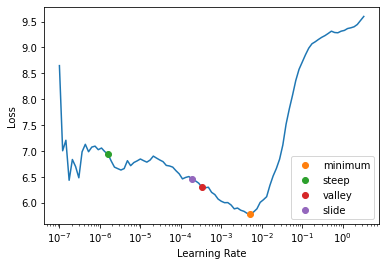

In [14]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [14]:
#4 ciclos modelo base de mBART eslamxm/MBART-finetuned-Spanish (50, 10) batch size= 1
learn.fit_one_cycle(4, lr_max=0.0006309573538601399, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,3.687307,3.640873,0.309830,0.121615,0.244606,0.244682,0.705932,0.661241,0.682056,23:37
1,2.434027,2.700396,0.416706,0.219104,0.345381,0.345113,0.764131,0.706426,0.733476,22:43
2,1.119833,1.905820,0.571923,0.406836,0.510689,0.510788,0.826971,0.776418,0.800324,23:50
3,0.650932,1.837321,0.622281,0.477601,0.573849,0.573709,0.850761,0.804794,0.826564,24:13


#### Exporting and importing trained model 

In [ ]:
#EXPORT MODEL
learn.metrics=None
learn=learn.to_fp32()
learn.export(fname='4cycles50_10bs1.pkl')

In [6]:
infer=load_learner(fname='4cycles50_10bs1.pkl')

# TEST

In [4]:
df2 = pd.read_csv('Datasets/test.csv', error_bad_lines=False, sep=';')
df2 = df2[['cod','original','simplified']]

df2 = df2.applymap(str)
articles2 = df2


n_labels2 = len(articles2["original"].unique())
print(n_labels2)
#articles2

1413


/tmp/ipykernel_803648/1431170592.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df2 = pd.read_csv('Datasets/test.csv', error_bad_lines=False, sep=';')


In [18]:
articles2

,cod,original,simplified
0,4921,House de la psicología” por su modo de expresarse directo y su uso apabullante de la lógica.,House de la psicología” por su modo de expresarse directo y su uso apabullante de la razonamiento.
1,151,"Ambas han coincidido en la necesidad de apostar por una atención sanitaria más personalizada, multidisciplinar y corresponsable, que cuente con la participación efectiva de pacientes y organizaciones de pacientes, y en la que las intervenciones vayan encaminadas a liberar recursos económicos y de tiempo","Ambas han coincidido en la necesidad de apostar por una atención sanitaria más personalizada, multidisciplinar y corresponsable, que cuente con la participación real de pacientes y organizaciones de pacientes, y en la que las intervenciones vayan encaminadas a liberar recursos económicos y de tiempo"
2,3830,"En él fue enterrado en 1616 por propio deseo Miguel de Cervantes, que además de vecino del barrio y haber tenido su última morada en la cercana calle de Francos, (de Cervantes ahora)","En él fue enterrado en 1616 por propio deseo Miguel de Cervantes, que además de vecino del barrio y haber tenido su última residencia en la cercana calle de Francos, (de Cervantes ahora)"
3,5023,"Tengo la convicción de que el envejecimiento activo y la solidaridad intergeneracional requieren, entre otras cosas, de la participación de cada persona en la sociedad a lo largo de la vida, de forma que se aseguren las oportunidades y el acceso a los servicios, las actividades políticas, sociales, recreativas y culturales, así como el voluntariado, porque con todo ello ayuda a mantener a las personas mayores en las redes de relación social, reduciendo su aislamiento.","Tengo la convicción de que el envejecimiento activo y la solidaridad intergeneracional requieren, entre otras cosas, de la participación de cada persona en la sociedad a lo largo de la vida, de forma que se aseguren las oportunidades y el acceso a los servicios, las actividades políticas, sociales, de entretenimiento y culturales, así como el voluntariado, porque con todo ello ayuda a mantener a las personas mayores en las redes de relación social, reduciendo su aislamiento."
4,1908,"El sol es esencial para la vida, pero también presenta efectos negativos para la salud que pueden derivar de exposiciones inadecuadas.Resultan especialmente nocivas las exposiciones sin protección en las edades infantiles y juveniles, que se relacionan con un mayor riesgo de padecer cáncer de piel.","El sol es esencial para la vida, pero también presenta efectos contraproducentes para la salud que pueden derivar de exposiciones inadecuadas.Resultan especialmente nocivas las exposiciones sin protección en las edades infantiles y juveniles, que se relacionan con un mayor riesgo de padecer cáncer de piel."
...,...,...,...
1820,4596,"Después de la guerra, Agapito estuvo en la cárcel, estuvo menospreciado mucho tiempo porque era republicano y todo eso","Después de la guerra, Agapito estuvo en la cárcel, estuvo arrinconado mucho tiempo porque era republicano y todo eso"
1821,2359,"""Este procedimiento culminará con la elaboración de un real decreto muy esperado por la comunidad sorda, ya que implica el compromiso ineludible con la difusión, transmisión, documentación, investigación, preservación, protección, promoción, valorización y revitalización de estas lenguas largamente minorizadas"", explicó la CNSE","""Este procedimiento terminará con la elaboración de un real decreto muy esperado por la comunidad sorda, ya que implica el compromiso ineludible con la difusión, transmisión, documentación, investigación, preservación, protección, promoción, valorización y revitalización de estas lenguas largamente minorizadas"", explicó la CNSE"
1822,2247,"Se trata de una metodología que normalmente se aplica en el centro con un profesional de apoyo, pero también ofrece la posibilidad de que estas sesiones se desarrollen en casa en el caso de que los participantes tengan dificultades para acud

# Predict on one example

In [12]:
print("ORIGINAL: "+articles2["original"][1])

ORIGINAL: Ambas han coincidido en la necesidad de apostar por una atención sanitaria más personalizada, multidisciplinar y corresponsable, que cuente con la participación efectiva de pacientes y organizaciones de pacientes, y en la que las intervenciones vayan encaminadas a liberar recursos económicos y de tiempo


In [13]:
print("SIMPLIFIED: "+articles2["simplified"][1])

SIMPLIFIED: Ambas han coincidido en la necesidad de apostar por una atención sanitaria más personalizada, multidisciplinar y corresponsable, que cuente con la participación real de pacientes y organizaciones de pacientes, y en la que las intervenciones vayan encaminadas a liberar recursos económicos y de tiempo


#### Prediction

In [7]:
output = infer.blurr_generate(articles2["original"][1], num_return_sequences=1)

In [8]:
output

[{'generated_texts': 'Ante la necesidad de proporcionar a las asociaciones sanitarias, con el tiempo de financiación de la participación de las organizaciones cuádrices, y con el objetivo de llegar a las organizaciones cuádrices de pacientes.'}]